In [1]:
import numpy as np
from matplotlib import pylab as plt
%autosave 0
%matplotlib inline

Autosave disabled


# Sentimental Analysis (Introduction)

### What is Sentimental Analysis?

Sentimental Analysis (aka "Opinion Mining") is the technique of analyzing the natural language used in subjective text-data to perceive and identify emotions. To classify a person's sentiment toward a particular subject brought up via survey responses, reviews, social media posts, email, or any other kind of textual sample, we typically generate a vocabulary based off of any relevant words used in said sample. We can then utilize that vocabulary to make classifications regarding how positive or negative the sentiment of a particular text sample is.

### Basic Classification Example

| Customer Feedback       | Sentiment | 
| ---                     | ---       |
|"An amazing product for a great price" | Positive |
|"This product is not worth the price" | Negative |





### Why use Sentimental Analysis?

In our modern environment, many companies, especially those that do business on the internet, need to sift through potentially thousands of user reviews in order to get a general idea of the sentiment toward a product. It is not usually feasible for a human to manually review that data and this is where sentiment analysis and machine learning come into play. By running product reviews through sentiment analysis and machine learning algorithms, companies can gain a general understanding of consumer sentiment and make important design decisions about a current or future product. Sentimental Analysis can also be utilized in making investment decisions on the stock market by analyzing news sources and social media to gain an understanding of how other people feel about a particular security.

### Our approach


For our project, we decided to perform sentimental analysis on a couple of Amazon review datasets, each of which containing over 100,000 different user reviews, along with their scores out of 5. When generating our target values, we considered a review to be "positive" if it had a score of 3.5 or above, and any review with a score less than 3.5 was considered to be negative.  

The baseline classifiers that we chose were Random Forest and Decision Trees, and we compared their performance to that of a feed forward neural network. We found that the f1 score for the Random Forest classifier on the video game review dataset to be approximately 0.90. Our decision tree outputted an average f1 score of 0.83.  The neural network actually ended up performing very similarly to the decision tree with an average accuracy of .85. Out of the three different classifiers that we tested, Random Forest seemed to perform the best on a consistent basis, regardless of the dataset.

# Feature Extraction and Selection
- The following code block is taken from this page: https://nijianmo.github.io/amazon/index.html
    - This is also the page where we acquired all of our samples throughout the project
- It extracts all of the data from a given json file (must first be extracted from a .gz file) into a pandas dataframe 


In [2]:
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [3]:
import pandas as pd
import gzip
import json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

- Since all of our datasets contain 100,000+ samples, we only extract the specified number of features (max_features) into our featuresets
- Here, we are also defining labels for our features
    - If a review has a score of 3.5 or greater, we consider it a positive review (represented as a 1)
    - Otherwise, if a review has a score less than 3.5 we consider it negative (represented as a 0)

In [4]:
# feature selection
def select_features(df, max_features):
    X = df['reviewText']
    y = df['overall']

    features = np.array(X.tolist()[:max_features])
    scores = np.array(y.tolist()[:max_features])
    
    # # shuffle the datasets in the same order
    # p = np.random.permutation(max_features)
    # features = features[p]
    # scores = scores[p]

    final_labels = []
    
    # generate labels
    for i in range(len(features)):
        if scores[i] >= 3.5:
            final_labels.append(1)
        else:
            final_labels.append(0)
    final_labels = np.array(final_labels)
    return (features, final_labels)


# Vocabulary Generation (Bag of Words)
The following block of code is partially taken from: https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/

- The text vectorization technique that we chose to utilize in this project was the "Bag of Words" technique
    - Bag of Words is a very simple and common word embedding method used on Natural Language Processing 
        - The algorithm develops a vocabulary for a given set of documents (often referred to as a "corpus"), and records the frequency of each word as they appear across said corpus.
        - The dataset of word frequencies is then used as the feature-set for training and testing our classifiers 
- We chose to use Keras' implementation of text vectorization as it provides a simple interface for constructing a bag of words for a given text dataset while still being incredibly flexible.
    - This implementation happens to perform a lot of text preprocessing by default in order to remove noise from the dataset 
        - Converts all words to lower case
        - Strips away punctuation
        - Splits all of the samples on whitespace
- The following function returns a text vectorization model (Bag of Words) that can be adapted to just about any text-dataset.

In [5]:
def create_bow_model(features, max_features):
    # creates an object for each item inside of a given tensor then adds them all into a list
    text_dataset = tf.data.Dataset.from_tensor_slices(features)

    max_features = max_features  # Maximum vocab size.
    max_len = 4  # Sequence length to pad the outputs to.
    embedding_dims = 2

    # Create the vectorization layer (layer for generating the bag of words) 
    vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='count')

    vectorize_layer.adapt(text_dataset.batch(64))
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)

    return model

The following function simply takes in text features and runs them through the vectorization model above.

In [6]:
#generate bag of words from selected features
def generate_bow(features, max_features, model):
    input_data = features
    input_data.shape = (max_features, 1)
    features_bow = model.predict(input_data)
    return features_bow

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

# Baseline Classifiers
### Random Forest
- One of the baseline classifiers that we chose for comparison with Feed Forward Neural network
- Out of all of the baseline classifiers we tried on the review datasets, Random Forest appeared to produce the best F1 score
- We decided to go with Scikit Learn's implementation of Random Forest as it gave us the best results
    - implementation can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    

In [8]:
def run_random_forest(features, labels):
    classifier = RandomForestClassifier(n_estimators=10)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict_proba(X_test)
    #calculate f1 scores
    y_pred=y_pred[:,1]>=0.3
    y_pred_int = y_pred.astype(np.int)
    score = f1_score(y_test, y_pred_int)

    return score

### Decision Tree
- We decided to include a second baseline classifier for further comparison
- After observing the performance of the Random Forest classifier on our datasets, we decided to see how Decision Trees might perform.
- While Random Forest classification utlizes several tree structures, descision trees only make use of a single tree structure. 
- Overall we expected our Decision Tree to perform worse than the other classifiers
    - While the decision tree classifier did not perform quite as well as our Random Forest, it still performed better than expected with f1 scores only marginally lower than our decision tree and Neural Network.
- We decided to utilize Scikit Learn's implementation found here: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [9]:
def run_decision_tree(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.33, random_state=42)

    nc = DecisionTreeClassifier(random_state = 2)
    nc.fit(X_train,y_train)

    y_pred = nc.predict_proba(X_test)
    y_pred=y_pred[:,1]>=0.3
    y_pred_int = y_pred.astype(np.int)
    score = f1_score(y_test, y_pred_int)

    return score

### Why use F1 scores instead of more traditional measurements of accuracy?

- We were finding that a lot of our data was very skewed in one direction over another
    - A lot of Datasets had significantly more postive reviews than negative and vice-versa
    - We chose to measure the performance of our baseline classifiers using f1 scores, as our classifiers were coming up with a lot of false positives or false negatives
- F1 score implementation inspired by this article: https://towardsdatascience.com/social-media-sentiment-analysis-part-ii-bcacca5aaa39

# Feed Foward Neural Network 

### Basic Description
A feed forward neural network is a type of neural network classifier where data is fed through a series of "layers" in a single direction before reaching an output (hence the name).  These types of neural networks can be represented as a "directed acyclic graph" or "DAG". It is a classification algorithm where input "nodes" are organized in the form of layers. The data is first passed into an "input" layer and flows through a series of "hidden layers" which run inputs through different functions until it reaches the output node, often referred to as the "activation function". Below is an image that gives an idea of the general structure of a typical feed forward neural network. 

### Explanation of our Neural Network implementation

We have implemented a Sequential constructor which, is considered to be a stack of layers. This Sequential constructor consists of Dense Layer which is a standard, profoundly interconnected neural network layer. This Dense layer is used as an output and input parameters. A single Dense Layer represents the output of an activation function. This activation function computes the dot product between the input values and the weight value and then it adds it to the bias for better optimization of the function. Dense Layers are commonly used in neural network architecture. 


We have three Dense layers the first two have 32 and 12 nodes with the 'ReLU' as our activation feature. These nodes form the layer and help the transfer of data to another layer as in a feed-forward neural network the data is not recognized by the layer before the current layer. Hence there is no feedback among layers. 
ReLU is a linear function that will output the input directly if it's positive or 1. ReLU is easier to train and performs better. Sigmoid is for the outer layer activation. The sigmoid is a logistic function that computes the probably for the problem. It displays values between 0 and 1 and is widely used for Sentiment Analysis.

In [10]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Convolution1D, GlobalMaxPooling1D

In [11]:
def build_nn_model():
    model = Sequential()
    #ReLU is widely used
    #sigmoid is used for the output layer
    #dense is basically adding layers to yout model for better input and output
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(12, activation = 'relu'))
    
    model.add(Dense(1, activation = 'sigmoid'))

    #binary_cross used for binary classificaiton problems
    # adam = for gradient descent 
    #metric because this is a classificaiton problem 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
def run_ffnn(features, labels, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.33, random_state=42)

    history = model.fit(X_train, y_train , validation_split = 0.33, epochs = 10 , batch_size = 10)


    loss, accuracy = model.evaluate(X_test, y_test)
    #the lower the loss the closer our predicitons are to the  labels 
    print("Loss = ", loss)
    print("Accuracy = ", accuracy)
    

    #to plot accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model for Accuracies on Training and Testing set ')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Testing'], loc = 'upper right')
    plt.show()
    
    #to plot loss 
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model for Loss ')
    plt.ylabel('Loss ')
    plt.xlabel('Epochs')
    plt.legend(['Training Loss ', 'Testing Loss'], loc = 'upper right')
    plt.show()
   
    #history object records training metrics for each epochs basically stores the variables 
    #validation split is our test size 
    #the more the epochs the more consistent the accuracy

### What is "loss" and why is it important?
The loss is a scalar value, the lower the loss the better our accuracies are for the data. For the computation of Loss, we have decided to use the function Binary Crossentropy. Binary Crossentropy is used for the prediction between features and predicted labels. As binary crossentropy works better with two labels such as 0 and 1 we decided to approach this loss function.
Adam is used as an optimizer to determine the gradient descent for a problem. It is commonly used for natural language processing. For output, the accuracies and data we decided to use verbose = 0 because verbose (0) is more silent and doesn't show the progress bar. The progress bar represents accuracy and loss and the amount of time consumed for each epoch and with the higher number of epochs used to train the model, it is taking more space.

# Results
### Video Game Dataset

In [13]:
df = getDF('./Video_Games_5.json.gz')
max_features = 10000
features, labels = select_features(df, max_features)

# generate a vocabulary (bag of words) for a given set of text features 
bow_model = create_bow_model(features, max_features)
features_bow = generate_bow(features, max_features, bow_model)

In [14]:
random_forest_score = run_random_forest(features_bow, labels)
print("F1 score for Random Forest Classifier:", random_forest_score)

F1 score for Random Forest Classifier: 0.9182534471437952


In [15]:
decision_tree_score = run_decision_tree(features_bow, labels)
print("F1 score for Decision Tree Classifier" , decision_tree_score)

F1 score for Decision Tree Classifier 0.8807274023890177


Epoch 1/10
449/449 [==============================] - 2s 5ms/step - loss: 0.4256 - accuracy: 0.8387 - val_loss: 0.3558 - val_accuracy: 0.8436
Epoch 2/10
449/449 [==============================] - 2s 5ms/step - loss: 0.2360 - accuracy: 0.8993 - val_loss: 0.3409 - val_accuracy: 0.8585
Epoch 3/10
449/449 [==============================] - 2s 5ms/step - loss: 0.1399 - accuracy: 0.9490 - val_loss: 0.5380 - val_accuracy: 0.8666
Epoch 4/10
449/449 [==============================] - 2s 4ms/step - loss: 0.0790 - accuracy: 0.9757 - val_loss: 0.6132 - val_accuracy: 0.8648
Epoch 5/10
449/449 [==============================] - 2s 4ms/step - loss: 0.0506 - accuracy: 0.9864 - val_loss: 0.6223 - val_accuracy: 0.8608
Epoch 6/10
449/449 [==============================] - 2s 4ms/step - loss: 0.0417 - accuracy: 0.9913 - val_loss: 0.7499 - val_accuracy: 0.8580
Epoch 7/10
449/449 [==============================] - 2s 4ms/step - loss: 0.0196 - accuracy: 0.9949 - val_loss: 0.8075 - val_accuracy: 0.8499
Epoch 

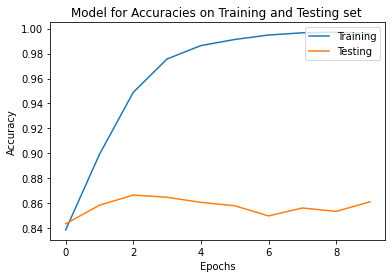

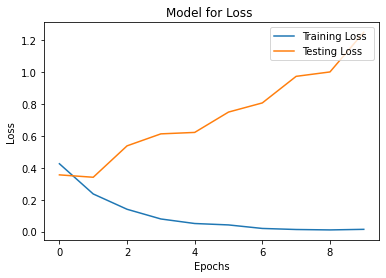

In [16]:
# feed forward neural network model 

nn_model = build_nn_model()
run_ffnn(features_bow, labels, nn_model)


Our accuracies for the training and testing set show a gap because of overfitting. The Loss increases as the testing set increases.The lower the loss the better the accuracies. 

### Movies and TV

In [17]:

df = getDF('Movies_and_TV_5.json.gz')
max_features = 10000
features, labels = select_features(df, max_features)

# generate a vocabulary (bag of words) for a given set of text features 
bow_model = create_bow_model(features, max_features)
features_bow = generate_bow(features, max_features, bow_model)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/home/appa/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-948bacb18085>", line 1, in <module>
    df = getDF('Movies_and_TV_5.json.gz')
  File "<ipython-input-3-0b1f65e1f75f>", line 13, in getDF
    for d in parse(path):
  File "<ipython-input-3-0b1f65e1f75f>", line 8, in parse
    yield json.loads(l)
  File "/usr/lib/python3.8/json/__init__.py", line 357, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.8/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.8/json/decoder.py", line 353, in raw_decode
    obj, end = self.scan_once(s, idx)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Trace

TypeError: object of type 'NoneType' has no len()

In [69]:
random_forest_score = run_random_forest(features_bow, labels)
print(("F1 score for Decision Tree Classifier" , random_forest_score)

SyntaxError: unexpected EOF while parsing (<ipython-input-69-ad52aac95c08>, line 2)

In [32]:
decision_tree_score = run_decision_tree(features_bow, labels)
print("F1 score for Decision Tree Classifier" , decision_tree_score)

F1 score for Decision Tree Classifier 0.8807274023890177


3300/3300 [==============================] - 0s 63us/step
Loss =  0.6640707534024224
Accuracy =  0.8518182039260864


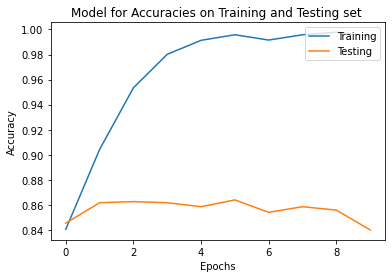

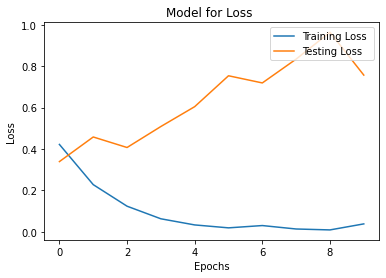

In [23]:
nn_model = build_nn_model()
run_ffnn(features_bow, labels, nn_model)

Our accuracies for the training and testing set represents  a gap largely due to overfitting, but with larger amount of samples this overfitting tends to reduce by a small number.The loss increases with the testing set as the number of epochs increases. 

# Contributions to this Project 

Hetansh 
- Implemented Feed Forward Neural Network
- Explanation of our feed forward implementation.
- Created/explained plots for Neural Network
- Wrote 'loss' description
- References 
- Added basic classification 
- Implemented Decision Tree classifier 

Matt
- Implemented feature selection and generated feature/label sets
- Implemented Text Vectorization (bag of words) algorithm
- Implemeted Random Forest Classifier
- Wrote Description of Bag of Words
- Wrote explanation for F1 scores
- Wrote basic description of Feed Forward Neural Networks
- Wrote explanations for baseline classsifiers

What we both worked on:
- Wrote "What is Sentimental Analysis?"
- Wrote "Why use Sentimental Analysis?"
- Wrote "Our Approach" 


## References 


1. Malik,Usman."Python for NLP: Movie Sentiment Analysis using Deep Learning in Keras." Stack Abuse.https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/. December 7, 2020.


2. Dumbleton,Rob."Complete Guide to Sentiment analysis: Updated 2020".Insights by Thematic.https://getthematic.com/insights/sentiment-analysis/. December 7, 2020.


3. Das, Deepak."Social Media Sentiment Analysis using Machine Learning: Part-1".towards data science. Sep 6, 2019.https://towardsdatascience.com/social-media-sentiment-analysis-49b395771197. December 7, 2020.


4.  Das, Deepak."Social Media Sentiment Analysis using Machine Learning: Part-2".towards data science. Sep 22, 2019.https://towardsdatascience.com/social-media-sentiment-analysis-49b395771197. December 7, 2020.


5. Brownless,Jason."How to Develop a Deep Learning Bag-of-Words Model for Sentiment Analysis(Text Classification)". Machine Learning Mastery, October 20,2017.https://machinelearningmastery.com/deep-learning-bag-of-words-model-sentiment-analysis/. December 7, 2020.


6. "Text Classification with Sentimental Analysis    ".     https://www.samyzaf.com/ML/imdb/imdb.html. December 7,2020.


7. McCaffrey,James."Sentiment Analysis Using Keras". Visual Studio Magazine, November 15, 2018. https://visualstudiomagazine.com/articles/2018/11/01/sentiment-analysis-using-keras.aspx. December 7, 2020


8. Brownlee,Jason."Your First Deep Learning Project in Python with Keras Step-By-Step".Machine Learning Mastery, July 24,2019. https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/. December 8, 2020.


9. Zhou,Victor."Keras for Beginners: Building Your First Neural Network". Victor Zhou/Blogs, June 14,2019.https://victorzhou.com/blog/keras-neural-network-tutorial/. December 8, 2020.


10. Jianmo Ni, Jiacheng Li, Julian McAuley,Empirical Methods in Natural Language Processing (EMNLP), 2019.https://nijianmo.github.io/amazon/index.html. November 21,2020.


11. Opperman, Artem."Sentiment Analysis with Deep Learning of Netflix Reviews".towards data science, Feb 24, 2019 . https://towardsdatascience.com/sentiment-analysis-with-deep-learning-62d4d0166ef6. December 7th, 2020.

12. Brownless,Jason."Display Deep Learning Model Training History in Keras".Machine Learning Mastery, October 3,2019. https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/. December 7, 2020. 


13. "Feedforward neural networks 1. What is feedforward neural network ?",26th April,2004. https://www.fon.hum.uva.nl/praat/manual/Feedforward_neural_networks_1__What_is_a_feedforward_ne.html. 7th December 2020.


14. Gupta,Tushar."Deep Learning: FeedForward Neural Network".towards data science, Jan 4, 2017. https://towardsdatascience.com/deep-learning-feedforward-neural-network-26a6705dbdc7. December 7, 2020.


15. "Sentimen Analysis: A Definite Guide". MonkeyLearn. https://monkeylearn.com/sentiment-analysis/. December 7, 2020.


